In [0]:
"""Importing all the relevant libraries we need."""

import pandas as pd # For data frames
import numpy as np # For math and efficient arrays
import matplotlib.pyplot as plt # For plotting and visualizing data

from sklearn.linear_model import LinearRegression

# So plots appear in this notebook
%matplotlib inline

In [0]:
""" Grab all the data from github, and read it into dataframes"""

# Get the housing price data
housing_data = pd.read_csv('https://raw.githubusercontent.com/Mvalentino92/JAVA/master/train.csv')

# Print the shape of the data, to see how many instances and features there are
print('There are',housing_data.shape[0],'instances,',housing_data.shape[1]-1,
      'features and of course 1 label.')

There are 1460 instances, 80 features and of course 1 label.


In [0]:
# EXERCISE: Is there any feature that should be immediately taken out?
# Maybe there's one thats there, but it really doesn't supply any reasonably correlated info to salesprice.
# Don't think too hard or far when looking! Just take this out right away!

# its the first one! Id
housing_data = housing_data.drop('Id',axis=1)

In [0]:
# Lets seperate the features from the labels
features = housing_data.drop('SalePrice',axis=1)
labels = housing_data['SalePrice']

In [0]:
# Lets split the data between categorical and numerical features so we can operate on each easier, and then recombine
features_cat = pd.DataFrame()
features_num = pd.DataFrame()
for ft in features.columns:
    if np.dtype(features[ft]) is np.dtype('O'):
        features_cat[ft] = features[ft]
    else:
        features_num[ft] = features[ft]

In [0]:
# Lets replace all the NaNs in the categorical dataframe with Missing
for ft in features_cat.columns:
        features_cat[ft].fillna('Missing',inplace=True)

In [0]:
# Now lets onehot encode this, it will return a matrix, so lets call it X_cat to distinguish from dataframes
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
X_cat = onehot.fit_transform(features_cat)

In [0]:
# Alright, now let's split the numerical features
# Since we need to combine the numerical and previously-categorical features back,
# We need to use a specific seed and test_size
test_size = 0.20
random_state=21

from sklearn.model_selection import train_test_split
train_features_num, test_features_num = train_test_split(features_num,test_size=test_size,random_state=random_state)

In [0]:
# Okay, now lets use an imputer to replace the NaNs for the numerical features
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_features_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [0]:
# The imputer will return a matrix, so we'll call is X_num
# Let's fit it to both train and test data
X_train_num = imputer.transform(train_features_num)
X_test_num = imputer.transform(test_features_num)

In [0]:
# Now let's split the previously-categorical feature matrix
X_train_cat, X_test_cat = train_test_split(X_cat,test_size=test_size,random_state=random_state)

In [0]:
# Okay, let's try some polynomial features. Although, I don't want to use the onehot encoded features
# When I generate this. It's just going to multiply a lot of things by 0 and 1, and not really introduce 
# new information. Plus it saves us on A LOT of features!
# Let's only use the numerical features, luckily we have all that saved
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2) # Do quadratic only
poly.fit(X_train_num) # We can just fit it with the train data, and transform both
X_train_num_poly = poly.transform(X_train_num)
X_test_num_poly = poly.transform(X_test_num)

In [0]:
# And let's combine all the training and test data now
X_train = np.hstack((X_train_num_poly,X_train_cat))
X_test = np.hstack((X_test_num_poly,X_test_cat))

In [0]:
# Now since the values are all over the place, let's use a scaler on the data
# Once again, you fit with training data, and transform on training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
# Finally, let's actually split the labels! 
y_train,y_test = train_test_split(np.array(labels),test_size=test_size,random_state=random_state)

In [0]:
# And compare to the actual values using some accuracy metric
# Im going to wrap this in a function
import sklearn.metrics as mt

def print_accuracies(y_test,y_predict,plot_it=True):
    # Mean squared error
    print('The MSE is: ',mt.mean_squared_error(y_test,y_predict))

    # Mean log squared error, but lets check for negatives first!
    hasneg = any([ele < 0 for ele in y_predict])
    if not(hasneg):
        print('The MSLE is: ',mt.mean_squared_log_error(y_test,y_predict))

    # Mean absolute error 
    print('The MAE is: ',mt.mean_absolute_error(y_test,y_predict))

    # mean absolute percfent error
    MAPE = np.sum(np.abs((y_test - y_predict)/y_test))*100/len(y_test)
    print('The MAPE is: ',MAPE)

    # Plot it
    if plot_it:
        plt.scatter(y_test,y_predict)
        plt.scatter(y_test,y_test)

In [0]:
# Printing individual predictions
def show_estimators(m,n,est,X_test,y_test):
    fig,axs = plt.subplots(m,n,figsize=(40,10))
    for i in range(0,m):
        for j in range(0,n):
            print('Estimator: ',i*n + j)
            y_predict = est[i*n + j].predict(X_test)
            print_accuracies(y_test,y_predict,plot_it=False)
            print('\n')
            axs[i,j].scatter(y_test,y_predict)
            axs[i,j].scatter(y_test,y_test)

In [0]:
# Gradient descent algorithm

def grad_descent(X,y,theta,alpha,iter):

    m = len(y)
    for i in range(0,iter):
        gradients = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - alpha*gradients
    
    return theta

In [0]:
# Lets create the function that will perform batched fuzzy regression
def BFR(X,y,Xtrue_test,ytrue_test,worse=10,n_estimators=10,alpha=1e-6,test_size=0.20,grad_iter=64,max_iter=512):

    # First let's split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

    # Make an empty team of estimators
    estimators = np.empty(n_estimators,dtype=object)

    # Make an empty array for each estimators group indices
    indices = np.empty(n_estimators,dtype=object)

    # How many samples each estimator gets, and the remainder.
    size,rem = divmod(X_train.shape[0],n_estimators)

    # Start the index for creating groups
    s = 0

    for i in range(0,n_estimators):

        # Construct Regressor
        p = LinearRegression()

        # Find end index, and update remainder to be distributed
        t = s + size + (rem > 0)
        rem = rem if rem == 0 else rem - 1

        # Grab new indices
        X_sub = X_train[range(s,t),:]
        y_sub = y_train[range(s,t)]

        # Add these indices to list
        indices[i] = (s,t)

        # Update s, to be one greater than t
        s = t

        # Fit and train the model, then add to list
        p.fit(X_sub,y_sub)
        estimators[i] = p
    
    # Append a column of 1's to X_train, save in new variable for gradient descent
    X_train_cpy = np.hstack((np.ones(X_train.shape[0]).reshape(-1,1),X_train))

    # Initially display info
    show_estimators(2,5,estimators,Xtrue_test,ytrue_test)

    # Init values for early stopping
    error0 = np.Inf
    error1 = np.Inf

    # Perform while error keeps going down
    while worse >= 0 and max_iter >= 0:

        # Init empty list for y labels for each estimator
        ys = np.empty(n_estimators,dtype=object)
        for i in range(0,n_estimators):
            ys[i] = np.array([])

        # Generate y labels for every group
        for i in range(0,n_estimators):

            # Group i get's the real labels
            s = indices[i][0]
            t = indices[i][1]
            ys[i] = np.append(ys[i],y_train[range(s,t)])

            # All other groups get groups i's prediction on this data
            predict = estimators[i].predict(X_train[range(s,t)])

            # Add all other groups
            for j in range(0,n_estimators):

                # Skip group i
                if i == j:
                    continue
                
                # Add predicted y labels
                ys[j] = np.append(ys[j],predict)
        
        # Have each group perform gradient descent using these labels
        for i in range(0,n_estimators):

            # Construct the theta column vector
            theta = np.append(estimators[i].intercept_,estimators[i].coef_).T

            # Call gradient descent using appended X_train and labels for this estimator
            theta = grad_descent(X_train_cpy,ys[i],theta,alpha,grad_iter)

            # Update this models coef_ and intercept_ values
            estimators[i].intercept_ = theta[0]
            estimators[i].coef_ = theta[1:]


        # Each group now predicts on the test set and we average errors   
        error = 0
        for i in range(0,n_estimators):
            error += mt.mean_squared_error(y_test,estimators[i].predict(X_test))

        # Average them
        error = error/n_estimators

        # Update the error for each
        error0 = error1
        error1 = error

        # Print error
        #print(error)

        # decrement max_iter
        max_iter -= 1

        # Decrement worse
        worse = worse if error1 <= error0 else worse - 1
    
    # Return the group of estimators
    return estimators

Estimator:  0
The MSE is:  1833063485.3324084
The MSLE is:  0.05351134169124109
The MAE is:  28686.698875873975
The MAPE is:  17.14077114705138


Estimator:  1
The MSE is:  1862985324.833848
The MSLE is:  0.03880777658791984
The MAE is:  24744.544181260007
The MAPE is:  13.959904167252901


Estimator:  2
The MSE is:  1415209283.665964
The MSLE is:  0.028813682495279904
The MAE is:  21840.613635681213
The MAPE is:  12.905164207737116


Estimator:  3
The MSE is:  1516040947.299487
The MSLE is:  0.03451349682817514
The MAE is:  23919.2608904585
The MAPE is:  13.624282454640689


Estimator:  4
The MSE is:  2198065422.258996
The MSLE is:  0.04770337652617153
The MAE is:  28049.227812038334
The MAPE is:  16.970331949218046


Estimator:  5
The MSE is:  1931286925.4017417
The MSLE is:  0.05334353142781077
The MAE is:  26200.750189741855
The MAPE is:  15.353124427492562


Estimator:  6
The MSE is:  1971142751.1110246
The MSLE is:  0.04540112296652267
The MAE is:  27028.891494529464
The MAPE is:

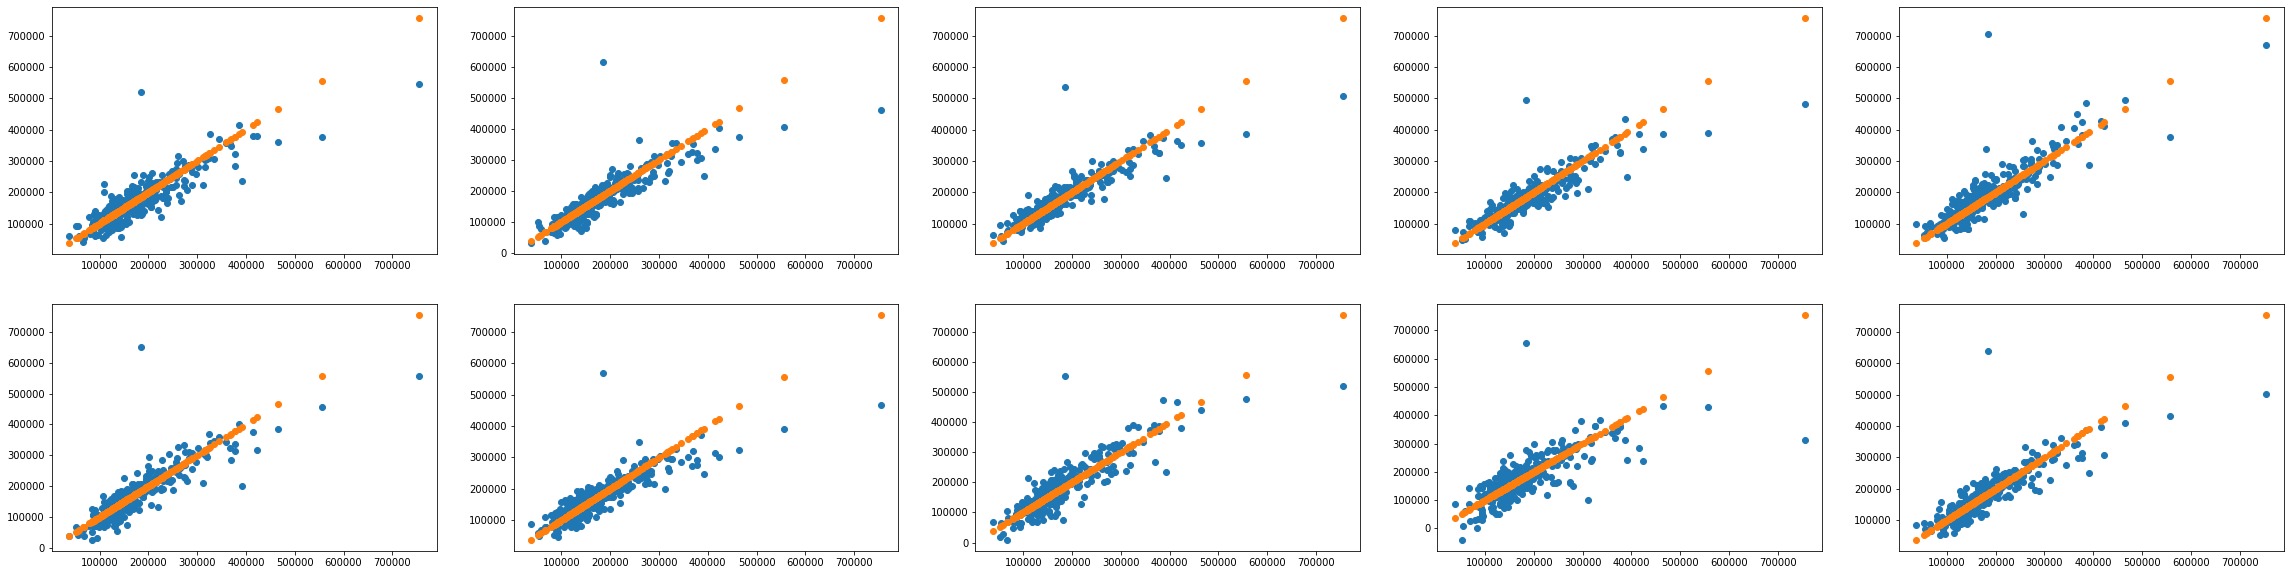

In [0]:
est = BFR(X_train,y_train,X_test,y_test,worse=2,alpha=1e-5,grad_iter=32,max_iter=1024)

The MSE is:  1348275887.5557122
The MSLE is:  0.023077265109604964
The MAE is:  19525.81813226125
The MAPE is:  11.651744068667279


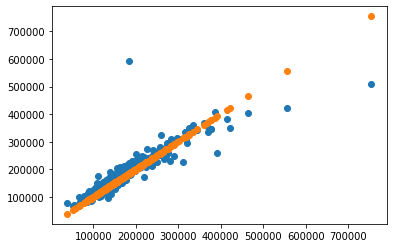

In [0]:
# Averaging all predictions
y_predict = 0
for i in range(0,len(est)):
    y_predict = y_predict + est[i].predict(X_test)

y_predict = y_predict/len(est)
print_accuracies(y_test,y_predict)

Estimator:  0
The MSE is:  1666323364.1902692
The MSLE is:  0.041932373844241894
The MAE is:  26648.629991009213
The MAPE is:  16.40960180979705


Estimator:  1
The MSE is:  1680170070.2233489
The MSLE is:  0.030148716152257102
The MAE is:  23158.39507711162
The MAPE is:  13.491811177703969


Estimator:  2
The MSE is:  1413309873.228453
The MSLE is:  0.029255348873557258
The MAE is:  22288.8079115542
The MAPE is:  13.591830383783224


Estimator:  3
The MSE is:  1475048830.5405335
The MSLE is:  0.03315343529407858
The MAE is:  24464.731718693158
The MAPE is:  14.622725975566643


Estimator:  4
The MSE is:  1954342045.3582265
The MSLE is:  0.0440879028661366
The MAE is:  26233.213903265674
The MAPE is:  16.463718756643733


Estimator:  5
The MSE is:  1823769647.3790886
The MSLE is:  0.03801579846635932
The MAE is:  25347.81509537779
The MAPE is:  14.939322948697951


Estimator:  6
The MSE is:  1796738606.504882
The MSLE is:  0.03906913989218485
The MAE is:  25701.10875229294
The MAPE is:

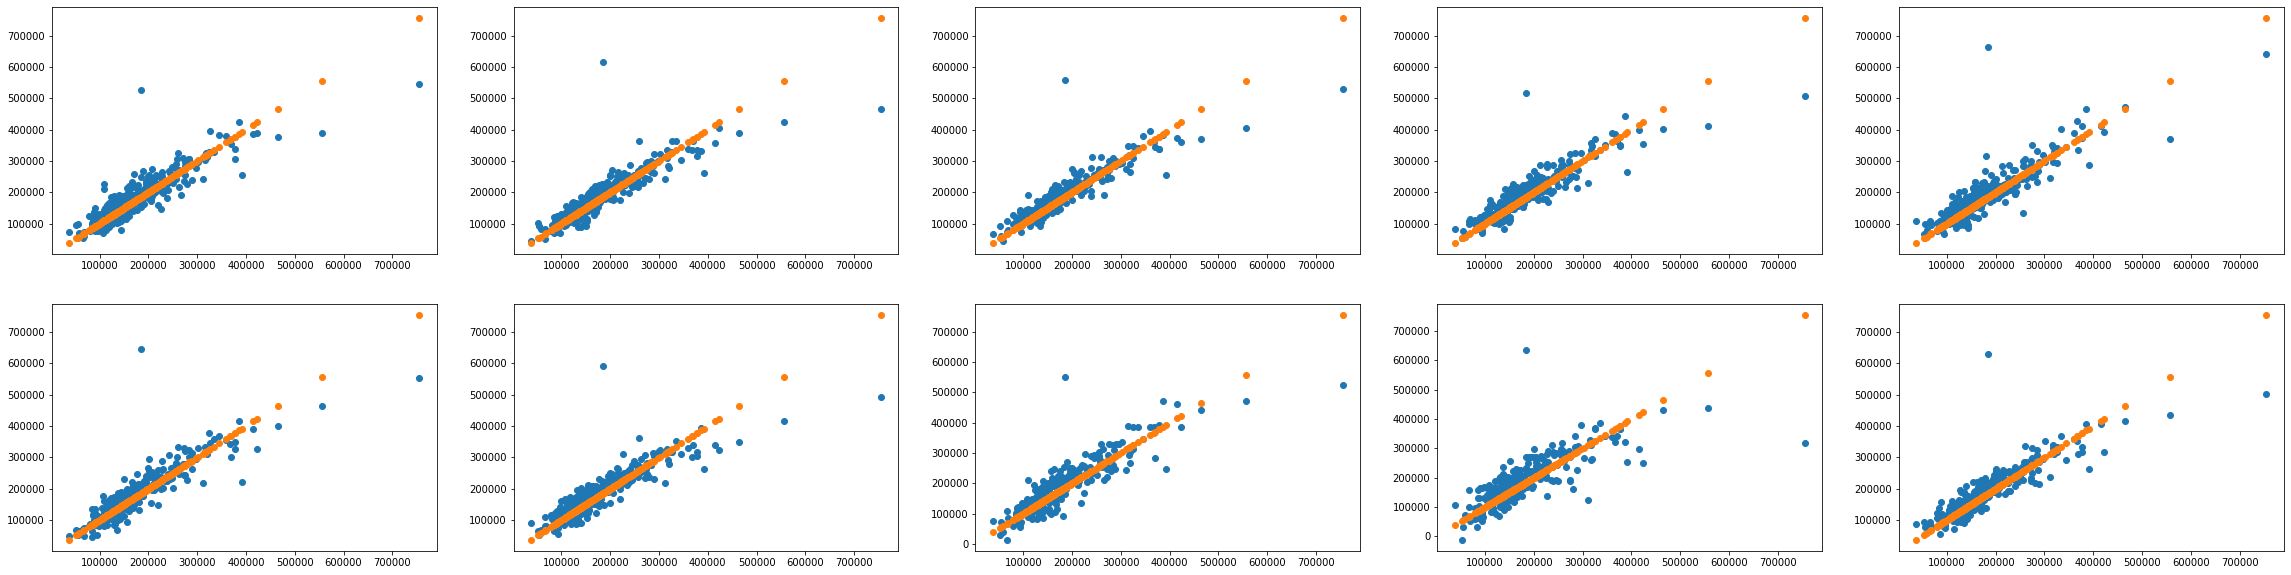

In [0]:
# Show each individual estimator after weakening
show_estimators(2,5,est,X_test,y_test)

The MSE is:  6.890268132323652e+21
The MAE is:  11785681516.235462
The MAPE is:  8505873.020098096


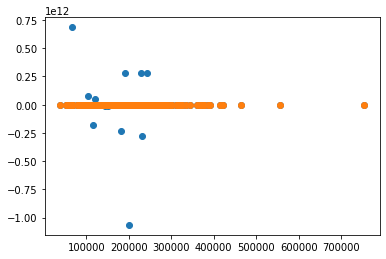

In [0]:
# Compare to a Poly Regression made on entire training data
y_predict = LinearRegression().fit(X_train,y_train).predict(X_test)
print_accuracies(y_test,y_predict)

The MSE is:  7967542925.8394575
The MAE is:  36562.750571162935
The MAPE is:  23.20178112835497


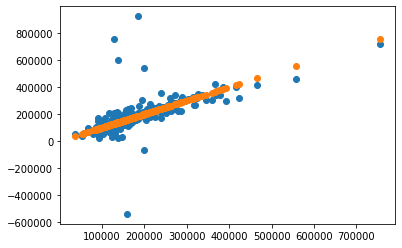

In [0]:
y_test2 = np.array([])
y_predict2 = np.array([])

for i in range(0,len(y_test)):
    if np.abs(y_predict[i]) < 1000000:
        y_test2 = np.append(y_test2,y_test[i])
        y_predict2 = np.append(y_predict2,y_predict[i])

print_accuracies(y_test2,y_predict2)